In [31]:
# imports
import pathlib, glob
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import lmfit

In [32]:
repo_root_dir = pathlib.Path().resolve().parent

xrd_data_dir = repo_root_dir.parent / "xrd_example_files"

xrd_data_file_paths = glob.glob(f"{xrd_data_dir}/*.csv")

In [33]:
xrd_data_file = xrd_data_file_paths[3]

In [34]:
def get_raw_file_name(xrd_file_path):
    """Returns the raw file name from the header of the given XRD file

    Args:
        xrd_file_path (pathlib.Path): The path to an XRD file with its original raw file
            name in the second field of the second line

    Returns:
        The raw file name from the header of the file as a string
    """
    with open(xrd_file_path, "r") as fp:
        line_1 = fp.readline()
        line_2 = fp.readline()
        raw_file_name = line_2.split(",")[-1]
    return raw_file_name


print(get_raw_file_name(xrd_data_file))

NN_StartingMaterials_Ba(NO3)2.raw



In [35]:
xrd_df = pd.read_csv(xrd_data_file, skiprows=2, names=["angle", "counts"])

In [36]:
def get_angle_interval_size(xrd_angles_column):
    """Given the "angle" column of an XRD dataframe, return the size of the steps between
    each measurement

    Args:
        xrd_angles_column (pandas.core.series.Series): The angular measurement column
            from an XRD csv file dataframe

    Returns:
        The spacing between each of the angle measurements as a float (one decimal place
        less precise than the original data, to account for rounding errors)

    Raises:
        ValueError: If more than one step size is found between datapoints in the column
    """
    interval_size = None
    angle_precisions = xrd_angles_column.apply(
        lambda x: len(str(x).split(".")[1]) if "." in str(x) else 0
    )
    max_precision = max(angle_precisions)
    step_sizes = xrd_angles_column.diff().dropna().round(max_precision - 1)
    if step_sizes.nunique() == 1:
        interval_size = step_sizes.iloc[0]
    else:
        raise ValueError(
            f"Angles are not all evenly spaced! Found intervals: {step_sizes.unique()}"
        )
    return interval_size


INTERVAL_SIZE = get_angle_interval_size(xrd_df["angle"])
print(f"Interval size is {INTERVAL_SIZE}")

Angles have at most 7 decimal places
interval size is 0.018586


In [37]:
MIN_N_INTERVAL_SEPARATION = 5
WINDOW_LENGTH = 50

peaks, _ = scipy.signal.find_peaks(
    xrd_df["counts"],
    prominence=np.std(xrd_df["counts"]),
    wlen=WINDOW_LENGTH,
    distance=MIN_N_INTERVAL_SEPARATION,
)
peak_angles = xrd_df["angle"].iloc[peaks]
peak_counts = xrd_df["counts"].iloc[peaks]

In [38]:
MIN_ANGLE = 10
NEIGHBORHOOD_SIZE = 100 * INTERVAL_SIZE

peak_segments = []
peak_angles_done = set()
for peak_angle, peak_count in zip(peak_angles, peak_counts):
    if peak_angle<MIN_ANGLE:
        continue
    if peak_angle in peak_angles_done:
        continue
    last_peaks_in_seg = []
    peaks_in_seg = [(peak_angle, peak_count)]
    while peaks_in_seg != last_peaks_in_seg:
        segment_min_angle = min([p[0] for p in peaks_in_seg]) - 0.5*NEIGHBORHOOD_SIZE
        segment_max_angle = max([p[0] for p in peaks_in_seg]) + 0.5*NEIGHBORHOOD_SIZE
        last_peaks_in_seg = peaks_in_seg
        peaks_in_seg = [
            (p_a, p_c)
            for p_a, p_c in zip(peak_angles, peak_counts)
            if p_a >= segment_min_angle - 0.5*NEIGHBORHOOD_SIZE and p_a <= segment_max_angle + 0.5*NEIGHBORHOOD_SIZE
        ]
    for p_a, p_c in peaks_in_seg:
        peak_angles_done.add(p_a)
    filtered_peaks = []
    for p_a, p_c in peaks_in_seg:
        nearby_peaks_counts = [p_c_other for p_a_other, p_c_other in peaks_in_seg if abs(p_a-p_a_other)<MIN_N_INTERVAL_SEPARATION*INTERVAL_SIZE and p_a_other!=p_a]
        if len(nearby_peaks_counts)<1 or p_c==max([p_c,*nearby_peaks_counts]):
            filtered_peaks.append((p_a,p_c))
    peaks_in_seg = filtered_peaks
    segment_min_angle = min([p[0] for p in peaks_in_seg]) - 0.5*NEIGHBORHOOD_SIZE
    segment_max_angle = max([p[0] for p in peaks_in_seg]) + 0.5*NEIGHBORHOOD_SIZE
    peak_segments.append(
        {"min": segment_min_angle, "max": segment_max_angle, "peak_angles": [p[0] for p in peaks_in_seg], "peak_counts": [p[1] for p in peaks_in_seg]}
    )
    print(
        f"Segment from {segment_min_angle} to {segment_max_angle} includes peaks at {[p[0] for p in peaks_in_seg]}"
    )

Segment from 18.084393199999997 to 19.9429932 includes peaks at [19.0136932]
Segment from 21.076707 to 22.935307 includes peaks at [22.006007]
Segment from 23.660133199999997 to 25.5187332 includes peaks at [24.5894332]
Segment from 26.0762872 to 27.934887200000002 includes peaks at [27.0055872]
Segment from 30.313849599999998 to 32.1724496 includes peaks at [31.2431496]
Segment from 35.8338322 to 39.6253554 includes peaks at [36.7631322, 38.4730258, 38.6960554]
Segment from 43.8071404 to 45.6657404 includes peaks at [44.7364404]
Segment from 48.0447028 to 51.2414804 includes peaks at [48.9740028, 50.3121804]
Segment from 54.568318600000005 to 56.575604999999996 includes peaks at [55.4976186, 55.646305]
Segment from 58.248307000000004 to 60.106907 includes peaks at [59.177607]


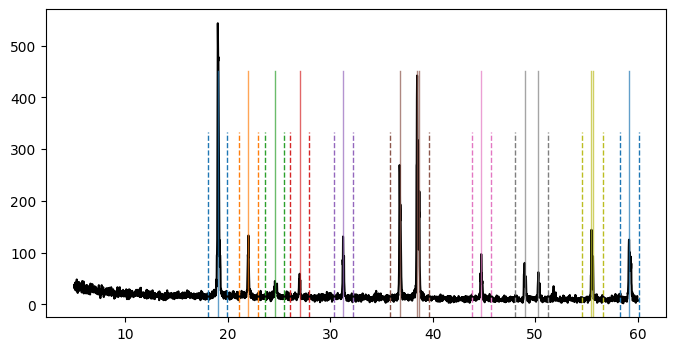

In [39]:
color_names = list(mcolors.TABLEAU_COLORS.keys())

f,ax = plt.subplots(figsize=(8.,4.))
ax.plot(xrd_df["angle"],xrd_df["counts"],color="black")
for i_seg, peak_segment in enumerate(peak_segments):
    color = color_names[i_seg%(len(color_names)-1)]
    ax.axvline(peak_segment["min"],color=color,linewidth=1,ymax=0.6,linestyle="--")
    ax.axvline(peak_segment["max"],color=color,linewidth=1,ymax=0.6,linestyle="--")
    for peak_angle in peak_segment["peak_angles"]:
        ax.axvline(peak_angle,color=color,linewidth=1,ymax=0.8,alpha=0.7)
plt.show()

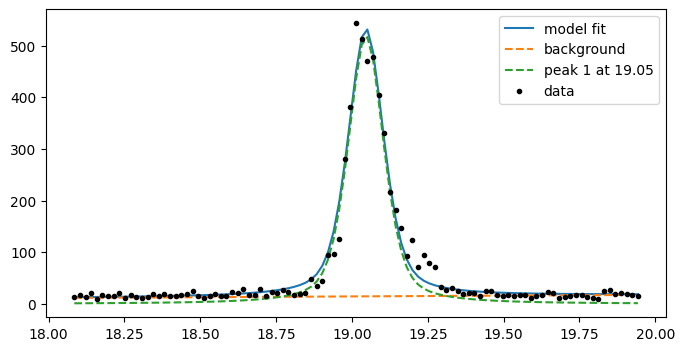

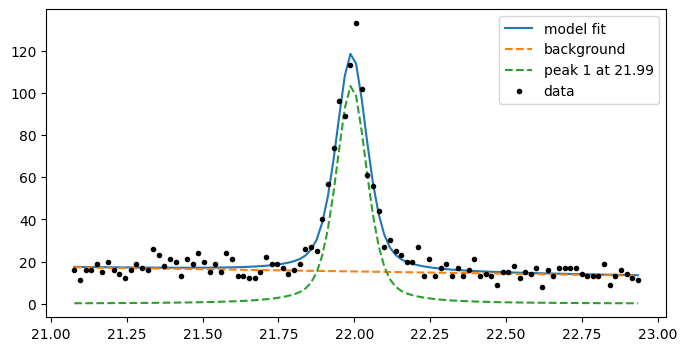

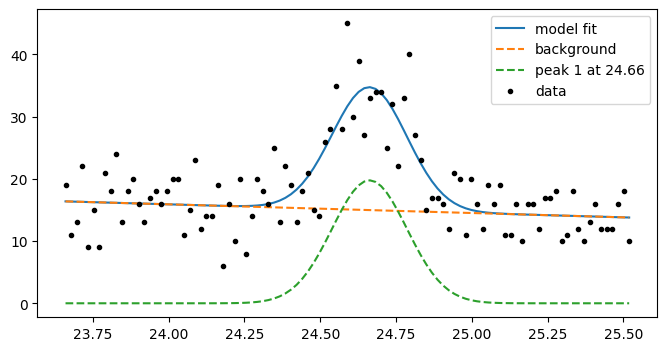

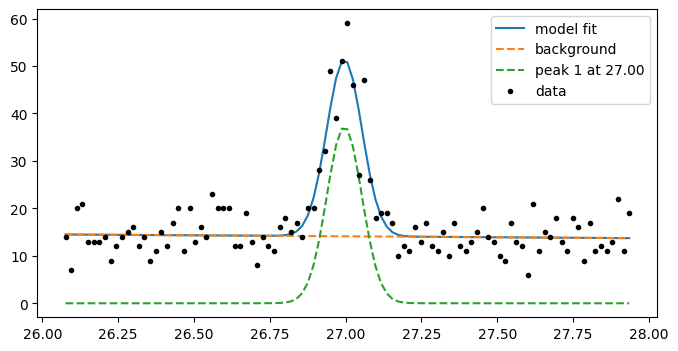

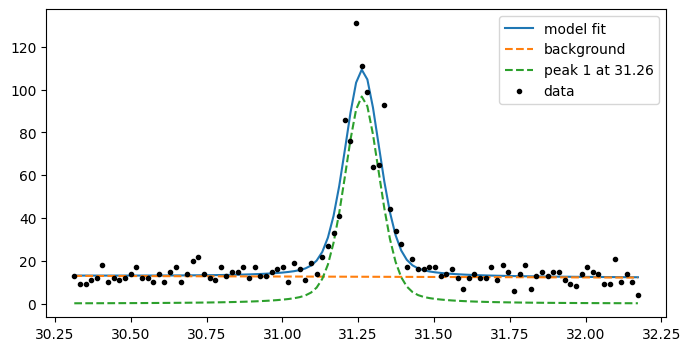

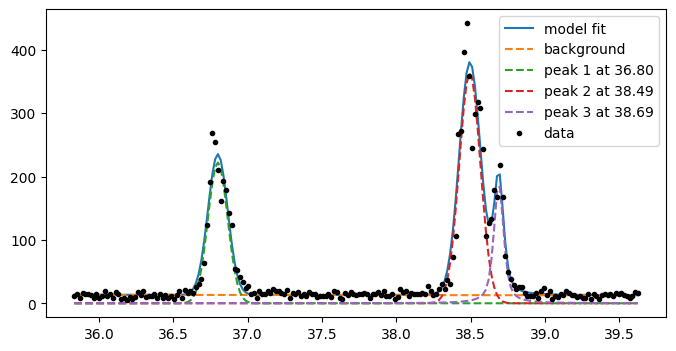

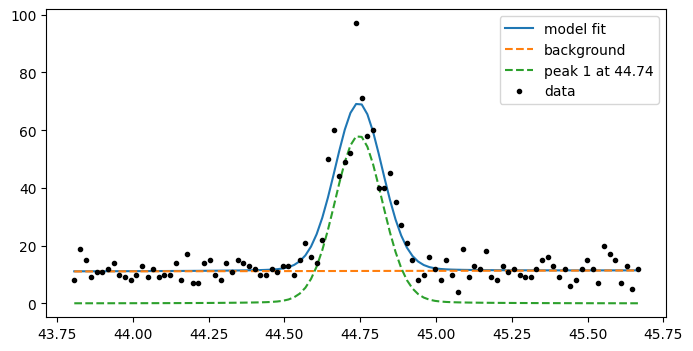

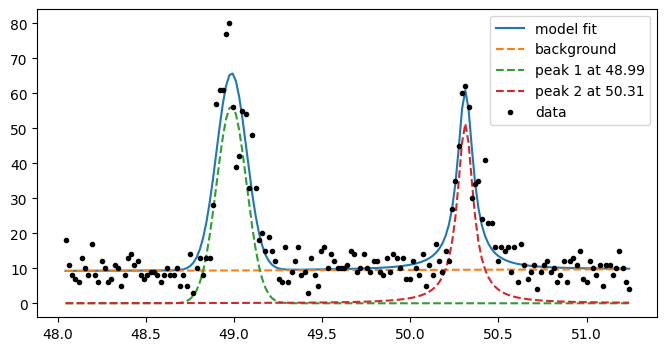

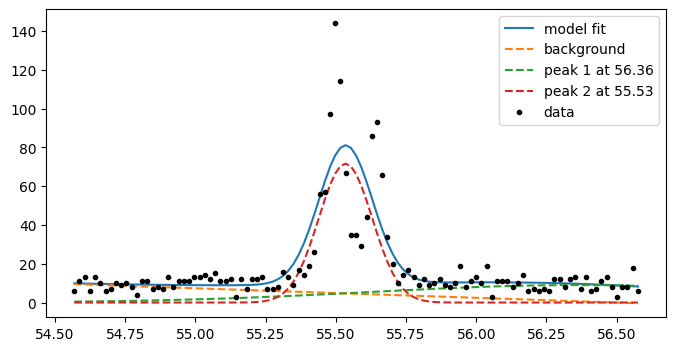

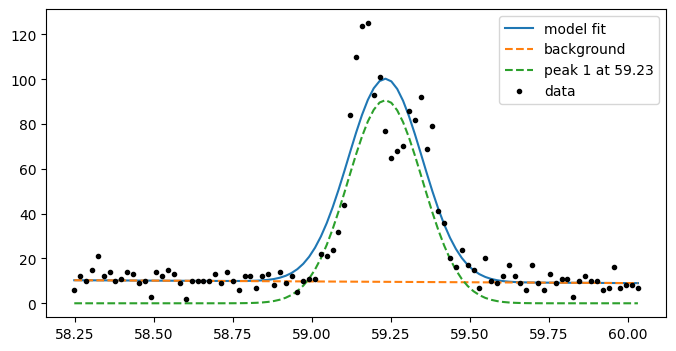

In [40]:
for test_peak_seg in peak_segments:
    seg_df = xrd_df[((xrd_df["angle"]>=test_peak_seg["min"]) & (xrd_df["angle"]<=test_peak_seg["max"]))]
    
    model = lmfit.models.LinearModel(prefix="linear_")
    all_make_params_kwargs = {
        "linear_slope":-0.01,
        "linear_intercept":0,
    }
    for i_p, (seg_peak_angle, seg_peak_counts) in enumerate(zip(test_peak_seg["peak_angles"], test_peak_seg["peak_counts"])):
        model+=lmfit.models.PseudoVoigtModel(prefix=f"voigt_{i_p}_")
        all_make_params_kwargs[f"voigt_{i_p}_amplitude"]=seg_peak_counts
        all_make_params_kwargs[f"voigt_{i_p}_center"]=seg_peak_angle
        all_make_params_kwargs[f"voigt_{i_p}_sigma"]=0.1*(np.max(seg_df["angle"])-np.min(seg_df["angle"]))
        all_make_params_kwargs[f"voigt_{i_p}_gamma"]=1
    
    params = model.make_params(**all_make_params_kwargs)
    # for i_p in range(len(test_peak_seg["peak_angles"])):
    #     params[f"voigt_{i_p}_amplitude"].min = 0
    #     params[f"voigt_{i_p}_center"].min = np.min(seg_df["angle"])
    #     params[f"voigt_{i_p}_center"].max = np.max(seg_df["angle"])
    
    result = model.fit(seg_df["counts"], params, x=seg_df["angle"])
    
    f,ax = plt.subplots(figsize=(8.,4.))
    ax.plot(seg_df["angle"], result.best_fit,label="model fit")
    ax.plot(seg_df["angle"], result.eval_components()["linear_"],label="background", linestyle="--")
    for i_p in range(len(test_peak_seg["peak_angles"])):
        ax.plot(seg_df["angle"], result.eval_components()[f"voigt_{i_p}_"],label=f"peak {i_p+1} at {result.params[f'voigt_{i_p}_center'].value:.2f}",linestyle="--")
    ax.plot(seg_df["angle"], seg_df["counts"],color="black",marker=".",linestyle="None",label="data")
    ax.legend(loc="best")
    plt.show()